In [1]:
import pandas as pd
import numpy as np
import os as os
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import acessos as ac
import re
from pylift import TransformedOutcome
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
query = """

with base_principal as (
select distinct
--a.id_customer
a.cpf 
, case when tp_publico_experimento = 'Alvo' then 1 else 0 end as f_tratamento
, case when vl_total_spending_m0 > 0 then 1 else 0 end as f_conversao
, b.ds_persona
, b.ds_perfil_research
, b.ds_seg_consumo
, cr.ds_rfe_perfil_credito
, i.nr_score_ie 
, i.nr_score_ie_conta 
from  platform_analytics_zone.pmm_pool_ds_cartoes_experimentos_metricas a
left join customer_analytics_zone.ca_analitico_basao_crm b 
	on (a.cpf = b.cd_cpf)
left join customer_curated_zone.ca_model_rfe_credito cr 
	on (a.id_customer  = cr.id_customer and date_trunc('month', date_add('day', -1, a.dt_comunicacao)) = cr.dt_referencia)
left join platform_curated_zone.transaction_dedicada_spending s 
	on (a.cpf = s.cpf)
left join customer_curated_zone.ca_model_ie_cliente i 
	on (a.cpf = i.cd_cpf and to_date(concat(cast(i.cd_yearmonth as varchar), '01') , 'yyyymmdd') = date_trunc('month', date_add('day', -1, a.dt_comunicacao))) 
)
, com_aleatorizacao as (
select 
*, row_number() over (partition by f_tratamento, f_conversao order by rand()) as ordem
from base_principal
)
select * from com_aleatorizacao
where ordem <= 100000


"""

df = ac.df_athena('flavia-costa', query)

In [3]:
len(df)

400000

In [4]:
df.dtypes

cpf                       object
f_tratamento               int64
f_conversao                int64
ds_persona                object
ds_perfil_research        object
ds_seg_consumo            object
ds_rfe_perfil_credito     object
nr_score_ie              float64
nr_score_ie_conta        float64
ordem                      int64
dtype: object

In [5]:
df.head()

,cpf,f_tratamento,f_conversao,ds_persona,ds_perfil_research,ds_seg_consumo,ds_rfe_perfil_credito,nr_score_ie,nr_score_ie_conta,ordem
0,62352586313,0,0,"16 - Homem, 25 a 40 anos, Nordeste",Multiplicador / Acumulador,SUPERMERCADO - 5,None,71.234246,78.205128,1
1,02986342361,0,0,"17 - Mulher, 25 a 40 anos, Sudeste e Sul",Multiplicador,ENTRETENIMENTO - 5,None,70.099957,58.974359,2
2,10862537444,0,0,"16 - Homem, 25 a 40 anos, Nordeste",Multiplicador,LOJAS DE DEPARTAMENTO - 4,None,54.237288,0.000000,3
3,14652813716,0,0,"20 - Homem, Até 24 anos, Sudeste e Sul",Multiplicador,None,None,54.710995,29.487179,4
4,01473714575,0,0,"19 - Mulher, 41 anos ou mais, Nordeste",Multiplicador / Acumulador,LOJAS DE DEPARTAMENTO - 5,None,0.000000,0.000000,5


In [6]:
df.isnull().sum()

cpf                           1
f_tratamento                  0
f_conversao                   0
ds_persona                 2959
ds_perfil_research        11339
ds_seg_consumo           182859
ds_rfe_perfil_credito    392268
nr_score_ie                 294
nr_score_ie_conta           294
ordem                         0
dtype: int64

In [7]:
id_columns = ['cpf', 'ordem']
cat_columns = df.drop(id_columns, axis = 1).select_dtypes('object').columns
num_columns = df.drop(id_columns, axis = 1).select_dtypes(exclude=['object']).columns

In [8]:
df.drop(id_columns, axis=1).describe()

,f_tratamento,f_conversao,nr_score_ie,nr_score_ie_conta
count,400000.000000,400000.000000,399706.000000,399706.000000
mean,0.500000,0.500000,46.978773,33.854261
std,0.500001,0.500001,30.933936,32.904500
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,6.779661,0.000000
50%,0.500000,0.500000,58.079096,29.487179
75%,1.000000,1.000000,71.790526,62.820513
max,1.000000,1.000000,100.000000,100.000000


In [9]:
df['f_conversao'].value_counts()

0    200000
1    200000
Name: f_conversao, dtype: int64

In [10]:
pd.crosstab(df.f_conversao, df.f_tratamento)

f_tratamento,0,1
f_conversao,,
0,100000,100000
1,100000,100000


In [11]:
df['f_uplift'] = np.where((df['f_tratamento'] == 1) & (df['f_conversao'] == 1), 1, 0)

In [12]:
df['f_uplift'].value_counts(normalize=True)

0    0.75
1    0.25
Name: f_uplift, dtype: float64

In [13]:
for column in df.columns:
  if df[column].dtype == 'object':
    df[column].fillna(df[column].mode()[0], inplace = True)
  elif df[column].dtype == 'string':
    df[column].fillna(df[column].mode()[0], inplace = True)
  elif df[column].dtype != 'object':
    df[column].fillna(df[column].median(), inplace = True)

In [14]:
df.isnull().sum()

cpf                      0
f_tratamento             0
f_conversao              0
ds_persona               0
ds_perfil_research       0
ds_seg_consumo           0
ds_rfe_perfil_credito    0
nr_score_ie              0
nr_score_ie_conta        0
ordem                    0
f_uplift                 0
dtype: int64

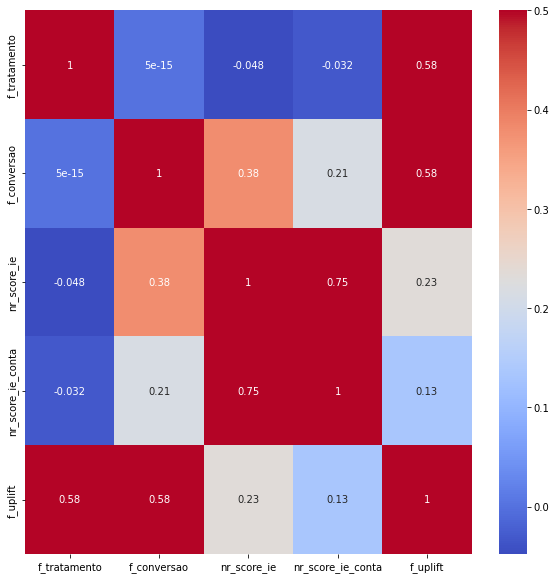

In [15]:
import seaborn as sns
plt.figure(figsize=(10,10))
sns.heatmap(df.drop(id_columns, axis=1).corr(), annot=True, cmap="coolwarm", vmax=0.5)
plt.show()

In [16]:
from sklearn.ensemble import RandomForestClassifier

In [17]:
df_model = pd.get_dummies(df, columns=cat_columns)

In [18]:
nao_preditor = ['cpf','ordem' , 'f_conversao', 'f_uplift']
target = ['f_conversao']

preditores = df_model.drop(nao_preditor, axis = 1).columns

In [19]:
df_model.isnull().sum()

cpf                                                                         0
f_tratamento                                                                0
f_conversao                                                                 0
nr_score_ie                                                                 0
nr_score_ie_conta                                                           0
                                                                           ..
ds_rfe_perfil_credito_05-Cliente maduro - Entrante ascensao                 0
ds_rfe_perfil_credito_06-Cliente maduro - Onliners medio - desaceleracao    0
ds_rfe_perfil_credito_07-Cliente maduro - Onliners medio - estavel          0
ds_rfe_perfil_credito_08-Cliente maduro - Super Onliners - desaceleracao    0
ds_rfe_perfil_credito_09-Cliente maduro - Super Onliners - estavel          0
Length: 158, dtype: int64

In [20]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier


In [21]:
x_train, x_test, y_train, y_test = train_test_split(df_model[preditores]
                                                    , df_model[target]
                                                    , random_state=42, test_size=0.20)

In [22]:
x_train = x_train.replace([np.inf, -np.inf], 0)
x_test = x_test.replace([np.inf, -np.inf], 0)

In [23]:
x_test_sim = x_test.copy()

x_test_sim['f_tratamento'] = 0

In [24]:
x_test_sim['f_tratamento'].sum()

0

In [25]:
x_test['f_tratamento'].sum()

40031

In [26]:
clf = RandomForestClassifier(n_estimators=400)
clf.fit(x_train, y_train)


/tmp/ipykernel_1064062/2067407183.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train, y_train)


RandomForestClassifier(n_estimators=400)

In [27]:
y_predicted_clf = clf.predict(x_test)
print(metrics.accuracy_score(y_test, y_predicted_clf).round(4))

0.6581


In [28]:
clf_results = pd.DataFrame()
clf_results['predito'] = y_predicted_clf
clf_results['real'] = y_test.values

df_confusion = pd.crosstab(clf_results.real, clf_results.predito)
df_confusion.head()

predito,0,1
real,,
0,25771,14159
1,13195,26875


<AxesSubplot:>

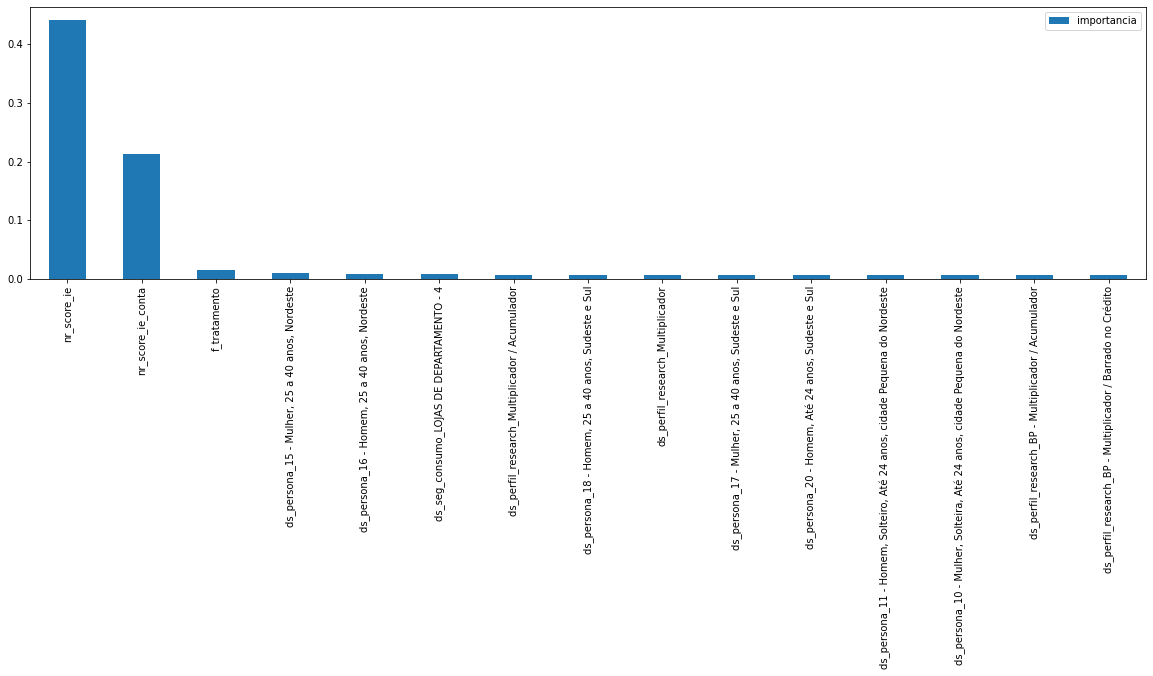

In [29]:
importance_df = pd.DataFrame(clf.feature_importances_, columns = ['importancia'], index = preditores)
importance_df.sort_values(by='importancia', ascending=False).head(15).plot.bar(figsize=(20,5))

In [30]:
y_predicted_clf_proba = clf.predict_proba(x_test)[:, 1]

clf_results['Probabilidade'] = y_predicted_clf_proba
clf_results['fx_score'] = np.round(clf_results['Probabilidade'], 1)
clf_results['cpf'] =  1

clf_results_agg = clf_results.groupby('fx_score').agg({'real': ['count', 'sum']})
clf_results_agg.columns = clf_results_agg.columns.droplevel(0)
clf_results_agg['taxa_evento'] = clf_results_agg['sum'] / clf_results_agg['count']
clf_results_agg

,count,sum,taxa_evento
fx_score,,,
0.0,4096,356,0.086914
0.1,6853,1341,0.195681
0.2,9032,2752,0.304694
0.3,8511,3434,0.403478
0.4,6798,3291,0.484113
0.5,7774,4406,0.566761
0.6,8348,5147,0.616555
0.7,9431,6111,0.647969
0.8,9421,6394,0.678697


In [31]:
y_predicted_proba_sim = clf.predict_proba(x_test_sim)[:, 1]

In [32]:
df_analise = x_test.copy()
len(df_analise)

80000

In [33]:
df_analise['prediction_actual'] = y_predicted_clf_proba
df_analise['prediction_sim'] = y_predicted_proba_sim

In [34]:
df_analise['ate'] = df_analise['prediction_actual'] - df_analise['prediction_sim']

<AxesSubplot:xlabel='ate', ylabel='Count'>

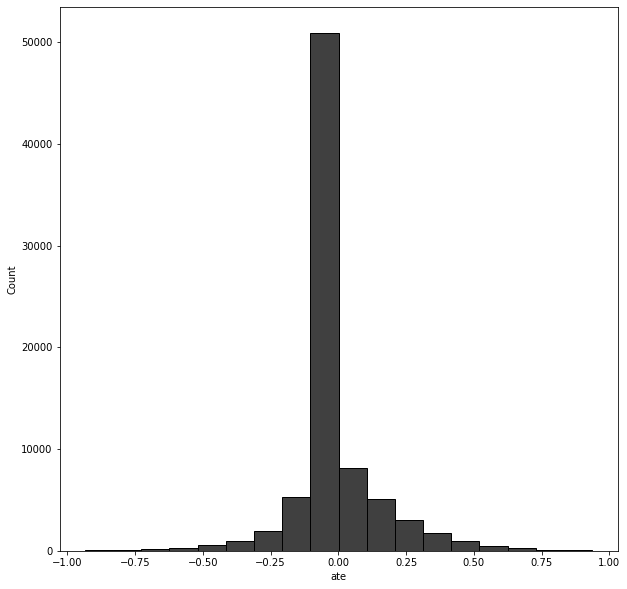

In [36]:
plt.figure(figsize=(10,10))
sns.histplot(data = df_analise, x = 'ate', color = "black")

In [37]:
df_analise['ate'].describe()

count    80000.000000
mean         0.009441
std          0.153308
min         -0.935530
25%          0.000000
50%          0.000000
75%          0.000000
max          0.936952
Name: ate, dtype: float64

In [41]:
df_analise['fx_ate'] = np.where((df_analise['ate'] < 0), "Conversão piora com Campanha",
                    np.where((df_analise['ate'] == 0) , "Campanha Indiferente", 
                    np.where((df_analise['ate'] > 0) & (df_analise['ate'] <= 0.25), "Leve melhora com a campanha",
                    "Melhora muito com campanha")))

df_analise['fx_ate'].value_counts()

Campanha Indiferente            40269
Conversão piora com Campanha    19903
Leve melhora com a campanha     14762
Melhora muito com campanha       5066
Name: fx_ate, dtype: int64

In [79]:
df_analise[['fx_ate', 'ate']].groupby('fx_ate').mean()

,ate
fx_ate,
Campanha Indiferente,0.000000
Conversão piora com Campanha,-0.139388
Leve melhora com a campanha,0.101662
Melhora muito com campanha,0.400469


In [80]:
df_analise[['prediction_actual', 'fx_ate']].groupby('fx_ate').mean()

,prediction_actual
fx_ate,
Campanha Indiferente,0.496207
Conversão piora com Campanha,0.362374
Leve melhora com a campanha,0.591609
Melhora muito com campanha,0.770797


<AxesSubplot:xlabel='ate', ylabel='prediction_actual'>

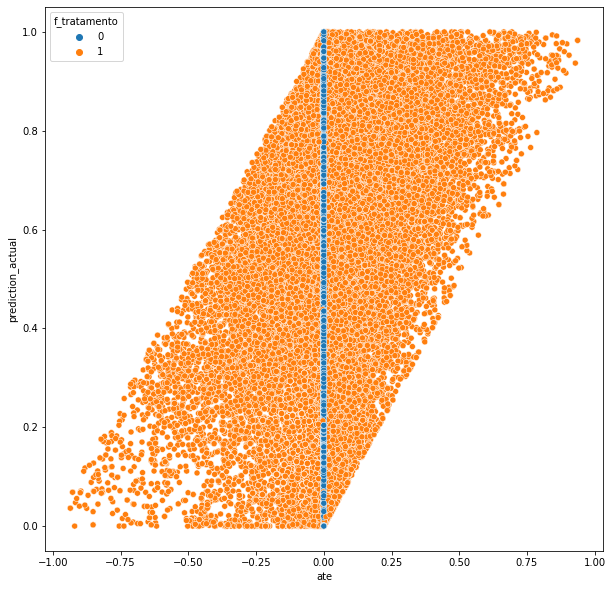

In [85]:
plt.figure(figsize=(10,10))
sns.scatterplot(data = df_analise, y = 'prediction_actual', x = 'ate', hue = 'f_tratamento')

In [43]:
for i in df_analise.columns:
    print(i)

f_tratamento
nr_score_ie
nr_score_ie_conta
ds_persona_0 - Mulher, Casada, 25 anos ou mais, cidade Pequena do Nordeste
ds_persona_1 - Mulher, Solteira, Até 24 anos, cidade Média do Sudeste ou Sul
ds_persona_10 - Mulher, Solteira, Até 24 anos, cidade Pequena do Nordeste
ds_persona_11 - Homem, Solteiro, Até 24 anos, cidade Pequena do Nordeste
ds_persona_12 - Mulher, Solteira, 35 anos ou mais, cidade Pequena do Nordeste, ensino fundamental cursando ou completo
ds_persona_13 - Homem, Solteiro, 35 anos ou mais, cidade Média do Norte ou Centro-Oeste
ds_persona_14 - Homem, Casado, 35 anos ou mais, cidade Pequena do Nordeste
ds_persona_15 - Mulher, 25 a 40 anos, Nordeste
ds_persona_16 - Homem, 25 a 40 anos, Nordeste
ds_persona_17 - Mulher, 25 a 40 anos, Sudeste e Sul
ds_persona_18 - Homem, 25 a 40 anos, Sudeste e Sul
ds_persona_19 - Mulher, 41 anos ou mais, Nordeste
ds_persona_2 - Mulher, Solteira, 35 anos ou mais, cidade Grande, Capital, do Nordeste
ds_persona_20 - Homem, Até 24 anos, Sudeste 

In [44]:
len(df_analise)

80000

In [45]:
len(x_test)

80000

In [56]:
df_comb = df_analise[['nr_score_ie', 'nr_score_ie_conta', 'fx_ate']].join(df[['ds_persona','ds_perfil_research','ds_seg_consumo','ds_rfe_perfil_credito']])

In [58]:
import funcionalidade as fc

df_comb['cont'] = 1

In [53]:
def discretiza(df, drop_col):
    num_columns = df.drop(drop_col, axis = 1).select_dtypes(exclude=['object']).columns
    stats = df.drop(drop_col, axis=1).describe()
    for i in num_columns:
        p75 = stats.iloc[6][i]
        p25 = stats.iloc[4][i]
        p50 = stats.iloc[5][i]
        
        df['aux'] = np.where((df[i] <= p25), "A - " + i,
                    np.where((df[i] > p25) & (df[i] <= p50), "B - " + i,
                    np.where((df[i] > p50) & (df[i] <= p75), "C - " + i, "D - " + i)))
  
        df = df.rename(columns = {'aux':i+"_fx"})

    return df

In [59]:
df_comb = discretiza(df_comb, ['cont'])

In [60]:
df_comb

,nr_score_ie,nr_score_ie_conta,fx_ate,ds_persona,ds_perfil_research,ds_seg_consumo,ds_rfe_perfil_credito,cont,nr_score_ie_fx,nr_score_ie_conta_fx
23218,44.558887,39.743590,Campanha Indiferente,"18 - Homem, 25 a 40 anos, Sudeste e Sul",BP - Multiplicador / Acumulador,MOBILIDADE - 6,07-Cliente maduro - Onliners medio - estavel,1,B - nr_score_ie,C - nr_score_ie_conta
20731,66.323338,80.769231,Campanha Indiferente,"16 - Homem, 25 a 40 anos, Nordeste",Multiplicador / Acumulador,LOJAS DE DEPARTAMENTO - 4,07-Cliente maduro - Onliners medio - estavel,1,C - nr_score_ie,D - nr_score_ie_conta
39555,39.209040,33.333333,Campanha Indiferente,"15 - Mulher, 25 a 40 anos, Nordeste",Multiplicador / Acumulador,SUPRIMENTOS PARA CASA - 3,07-Cliente maduro - Onliners medio - estavel,1,B - nr_score_ie,C - nr_score_ie_conta
147506,0.000000,0.000000,Campanha Indiferente,"12 - Mulher, Solteira, 35 anos ou mais, cidade...",Barrado no Crédito,LOJAS DE DEPARTAMENTO - 4,07-Cliente maduro - Onliners medio - estavel,1,A - nr_score_ie,A - nr_score_ie_conta
314215,66.440678,0.000000,Conversão piora com Campanha,"10 - Mulher, Solteira, Até 24 anos, cidade Peq...",BP - Multiplicador / Barrado no Crédito,E-COMMERCE - 3,07-Cliente maduro - Onliners medio - estavel,1,C - nr_score_ie,A - nr_score_ie_conta
...,...,...,...,...,...,...,...,...,...,...
54840,28.357236,80.769231,Campanha Indiferente,"19 - Mulher, 41 anos ou mais, Nordeste",Multiplicador,SAUDE - 6,07-Cliente maduro - Onliners medio - estavel,1,B - nr_score_ie,D - nr_score_ie_conta
103,0.000000,0.000000,Campanha Indiferente,"21 - Mulher, 41 anos ou mais, Sudeste e Sul",Multiplicador / Acumulador,SERVICOS DE ALIMENTACAO - 5,07-Cliente maduro - Onliners medio - estavel,1,A - nr_score_ie,A - nr_score_ie_conta
339434,66.692742,48.717949,Leve melhora com a campanha,"28 - Mulher, Até 24 anos, Centro-Oeste e Norte",BP - Multiplicador / Acumulador,LOJAS DE DEPARTAMENTO - 4,07-Cliente maduro - Onliners medio - estavel,1,C - nr_score_ie,C - nr_score_ie_conta
315677,53.759235,17.948718,Leve melhora com a campanha,"17 - Mulher, 25 a 40 anos, Sudeste e Sul",Multiplicador / Acumulador,FINANCAS - 5,07-Cliente maduro - Onliners medio - estavel,1,B - nr_score_ie,B - nr_score_ie_conta


In [61]:
colunas_analise = ['ds_persona', 'ds_perfil_research', 'ds_seg_consumo', 'ds_rfe_perfil_credito', 'nr_score_ie_fx', 'nr_score_ie_conta_fx']

report_combinacoes = fc.report_perfil_grupos(df_comb, 'fx_ate', 'cont', 0.05, 50, colunas_analise)


/home/flavia.costa/projetos/diretorio_trabalho/uplift-oportunidades/funcionalidade.py:562: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[coluna_contagem] = df[coluna_contagem].astype('int')


In [119]:
report_combinacoes.query('fx_ate == "Melhora muito com campanha"').query('diferenca > 0')

,segmento,n_seg_grupo,n_seg,n_grupo,total,per_grupo_seg,per_grupo_total,diferenca,diferenca_abs,fx_ate
9063,"- 15 Mulher, 25 a 40 anos, Nordeste Multiplica...",67,465,5066,80000,0.144086,0.063325,0.080761,0.080761,Melhora muito com campanha
6783,"- 15 Mulher, 25 a 40 anos, Nordeste Multiplica...",89,683,5066,80000,0.130307,0.063325,0.066982,0.066982,Melhora muito com campanha
6779,"- 15 Mulher, 25 a 40 anos, Nordeste Multiplica...",65,540,5066,80000,0.120370,0.063325,0.057045,0.057045,Melhora muito com campanha


In [76]:
print(report_combinacoes.query('fx_ate == "Melhora muito com campanha"').query('diferenca > 0')['segmento'].unique())

['- 15 Mulher, 25 a 40 anos, Nordeste Multiplicador LOJAS DE DEPARTAMENTO 4 07-Cliente maduro Onliners medio estavel D nr_score_ie nr_score_ie_conta'
 '- 15 Mulher, 25 a 40 anos, Nordeste Multiplicador LOJAS DE DEPARTAMENTO 4 07-Cliente maduro Onliners medio estavel D nr_score_ie'
 '- 15 Mulher, 25 a 40 anos, Nordeste Multiplicador LOJAS DE DEPARTAMENTO 4 07-Cliente maduro Onliners medio estavel C nr_score_ie']


In [77]:
report_combinacoes.query('fx_ate == "Leve melhora com a campanha"').query('diferenca > 0')

,segmento,n_seg_grupo,n_seg,n_grupo,total,per_grupo_seg,per_grupo_total,diferenca,diferenca_abs,fx_ate
18,- 06-Cliente maduro Onliners medio desaceleracao,81,205,14762,80000,0.395122,0.184525,0.210597,0.210597,Leve melhora com a campanha
10,- 04-Cliente maduro Entrante estavel,58,149,14762,80000,0.389262,0.184525,0.204737,0.204737,Leve melhora com a campanha
30,- 09-Cliente maduro Super Onliners estavel,105,277,14762,80000,0.379061,0.184525,0.194536,0.194536,Leve melhora com a campanha
26,- 08-Cliente maduro Super Onliners desaceleracao,52,138,14762,80000,0.376812,0.184525,0.192287,0.192287,Leve melhora com a campanha
13410,"- 28 Mulher, Até 24 anos, Centro-Oeste e Norte...",60,177,14762,80000,0.338983,0.184525,0.154458,0.154458,Leve melhora com a campanha
288,- SERVICOS DE ALIMENTACAO 6,69,210,14762,80000,0.328571,0.184525,0.144046,0.144046,Leve melhora com a campanha
14081,"- 28 Mulher, Até 24 anos, Centro-Oeste e Norte...",56,171,14762,80000,0.327485,0.184525,0.142960,0.142960,Leve melhora com a campanha
668,"- 28 Mulher, Até 24 anos, Centro-Oeste e Norte...",59,184,14762,80000,0.320652,0.184525,0.136127,0.136127,Leve melhora com a campanha
137,- LOJAS DE DEPARTAMENTO 6,122,383,14762,80000,0.318538,0.184525,0.134013,0.134013,Leve melhora com a campanha
660,"- 28 Mulher, Até 24 anos, Centro-Oeste e Norte...",101,341,14762,80000,0.296188,0.184525,0.111663,0.111663,Leve melhora com a campanha


In [78]:
print(report_combinacoes.query('fx_ate == "Leve melhora com a campanha"').query('diferenca > 0')['segmento'].unique())

['- 06-Cliente maduro Onliners medio desaceleracao'
 '- 04-Cliente maduro Entrante estavel'
 '- 09-Cliente maduro Super Onliners estavel'
 '- 08-Cliente maduro Super Onliners desaceleracao'
 '- 28 Mulher, Até 24 anos, Centro-Oeste e Norte BP Multiplicador / Acumulador LOJAS DE DEPARTAMENTO 4'
 '- SERVICOS DE ALIMENTACAO 6'
 '- 28 Mulher, Até 24 anos, Centro-Oeste e Norte BP Multiplicador / Acumulador LOJAS DE DEPARTAMENTO 4 07-Cliente maduro Onliners medio estavel'
 '- 28 Mulher, Até 24 anos, Centro-Oeste e Norte Barrado no Crédito'
 '- LOJAS DE DEPARTAMENTO 6'
 '- 28 Mulher, Até 24 anos, Centro-Oeste e Norte BP Multiplicador / Acumulador'
 '- FINANCAS 6' '- SUPERMERCADO 1'
 '- 11 Homem, Solteiro, Até 24 anos, cidade Pequena do Nordeste Barrado no Crédito'
 '- SUPERMERCADO 5' '- SERVICOS 3' '- SERVICOS DE ALIMENTACAO 4'
 '- SUPRIMENTOS PARA CASA 4'
 '- 9 Homem, Solteiro, Entre 25 e 34 anos, cidade Média do Norte ou Centro-Oeste'
 '- MOBILIDADE 6' '- FINANCAS 5' '- TELECOM 3' '- ENTRETE

In [88]:
print(report_combinacoes.query('fx_ate == "Conversão piora com Campanha"').query('diferenca > 0')['segmento'].unique())

['- 11 Homem, Solteiro, Até 24 anos, cidade Pequena do Nordeste Multiplicador LOJAS DE DEPARTAMENTO 4 07-Cliente maduro Onliners medio estavel A nr_score_ie nr_score_ie_conta'
 '- 11 Homem, Solteiro, Até 24 anos, cidade Pequena do Nordeste Multiplicador LOJAS DE DEPARTAMENTO 4 07-Cliente maduro Onliners medio estavel A nr_score_ie'
 '- 26 Homem, Até 24 anos, Nordeste Multiplicador LOJAS DE DEPARTAMENTO 4 07-Cliente maduro Onliners medio estavel A nr_score_ie'
 '- 26 Homem, Até 24 anos, Nordeste Multiplicador LOJAS DE DEPARTAMENTO 4 07-Cliente maduro Onliners medio estavel A nr_score_ie nr_score_ie_conta'
 '- 15 Mulher, 25 a 40 anos, Nordeste NI LOJAS DE DEPARTAMENTO 4 07-Cliente maduro Onliners medio estavel A nr_score_ie'
 '- 15 Mulher, 25 a 40 anos, Nordeste NI LOJAS DE DEPARTAMENTO 4 07-Cliente maduro Onliners medio estavel A nr_score_ie nr_score_ie_conta'
 '- 20 Homem, Até 24 anos, Sudeste e Sul BP Multiplicador / Acumulador LOJAS DE DEPARTAMENTO 4 07-Cliente maduro Onliners medio 

In [93]:
pd.crosstab(df_comb.fx_ate, df_comb.ds_perfil_research, normalize = 'columns')

ds_perfil_research,Acumulador,BP - Multiplicador / Acumulador,BP - Multiplicador / Barrado no Crédito,Barrado no Crédito,Multiplicador,Multiplicador / Acumulador,Multiplicador / Barrado no Crédito,NI
fx_ate,,,,,,,,
Campanha Indiferente,0.496504,0.500375,0.496033,0.486597,0.506037,0.517041,0.500930,0.495458
Conversão piora com Campanha,0.276541,0.262146,0.252727,0.238928,0.245190,0.222950,0.212749,0.279044
Leve melhora com a campanha,0.178552,0.180173,0.192231,0.225524,0.173221,0.192811,0.232669,0.173068
Melhora muito com campanha,0.048403,0.057306,0.059008,0.048951,0.075551,0.067197,0.053652,0.052430


In [95]:
pd.crosstab(df_comb.fx_ate, df_comb.ds_rfe_perfil_credito, normalize = 'columns')

ds_rfe_perfil_credito,02-Cliente novo - onliner,03-Cliente maduro - offliner,04-Cliente maduro - Entrante estavel,05-Cliente maduro - Entrante ascensao,06-Cliente maduro - Onliners medio - desaceleracao,07-Cliente maduro - Onliners medio - estavel,08-Cliente maduro - Super Onliners - desaceleracao,09-Cliente maduro - Super Onliners - estavel
fx_ate,,,,,,,,
Campanha Indiferente,0.389474,0.393939,0.389262,0.379310,0.312195,0.505227,0.340580,0.346570
Conversão piora com Campanha,0.157895,0.333333,0.154362,0.183908,0.268293,0.249076,0.239130,0.249097
Leve melhora com a campanha,0.442105,0.242424,0.389262,0.390805,0.395122,0.182014,0.376812,0.379061
Melhora muito com campanha,0.010526,0.030303,0.067114,0.045977,0.024390,0.063683,0.043478,0.025271


In [96]:
pd.crosstab(df_comb.fx_ate, df_comb.nr_score_ie_fx, normalize = 'columns')

nr_score_ie_fx,A - nr_score_ie,B - nr_score_ie,C - nr_score_ie,D - nr_score_ie
fx_ate,,,,
Campanha Indiferente,0.4780,0.490705,0.523124,0.521637
Conversão piora com Campanha,0.4332,0.192904,0.179741,0.189304
Leve melhora com a campanha,0.0727,0.247676,0.209890,0.207814
Melhora muito com campanha,0.0161,0.068716,0.087246,0.081245


In [97]:
df_comb['flag_homem'] = np.where(df_comb['ds_persona'].str.contains("Mulher"), 0, 1)

df_comb['flag_homem'].value_counts()

0    47136
1    32864
Name: flag_homem, dtype: int64

In [98]:
pd.crosstab(df_comb.fx_ate, df_comb.flag_homem, normalize = 'columns')

flag_homem,0,1
fx_ate,,
Campanha Indiferente,0.501570,0.505934
Conversão piora com Campanha,0.244442,0.255021
Leve melhora com a campanha,0.185782,0.182723
Melhora muito com campanha,0.068207,0.056323


In [116]:
pd.crosstab(df_comb.ds_seg_consumo, df_comb.fx_ate, normalize = 'index').sort_values(by = 'Melhora muito com campanha', ascending = False).head(50)

fx_ate,Campanha Indiferente,Conversão piora com Campanha,Leve melhora com a campanha,Melhora muito com campanha
ds_seg_consumo,,,,
EDUCACAO - 4,0.428571,0.214286,0.214286,0.142857
DELIVERY - 1,0.272727,0.272727,0.363636,0.090909
PET - 5,0.409091,0.136364,0.363636,0.090909
SUPERMERCADO - 6,0.486584,0.213561,0.216099,0.083756
PET - 3,0.448718,0.141026,0.333333,0.076923
E-COMMERCE - 5,0.548774,0.159624,0.217527,0.074074
LOJAS DE DEPARTAMENTO - 5,0.503051,0.209884,0.214765,0.072300
LOJAS DE DEPARTAMENTO - 1,0.469880,0.180723,0.277108,0.072289
LOJAS DE DEPARTAMENTO - 4,0.496839,0.296293,0.135157,0.071711


In [121]:
pd.crosstab(df_comb.nr_score_ie_fx, df_comb.ds_perfil_research, normalize = 'columns')

ds_perfil_research,Acumulador,BP - Multiplicador / Acumulador,BP - Multiplicador / Barrado no Crédito,Barrado no Crédito,Multiplicador,Multiplicador / Acumulador,Multiplicador / Barrado no Crédito,NI
nr_score_ie_fx,,,,,,,,
A - nr_score_ie,0.344412,0.275464,0.255041,0.290793,0.212326,0.212904,0.209827,0.305817
B - nr_score_ie,0.302893,0.240199,0.206942,0.211247,0.225472,0.322890,0.213811,0.224064
C - nr_score_ie,0.218027,0.247890,0.240992,0.214161,0.258964,0.277943,0.241169,0.236175
D - nr_score_ie,0.134667,0.236447,0.297025,0.283800,0.303238,0.186263,0.335193,0.233944


In [126]:
pd.crosstab(df_comb.ds_seg_consumo, df_comb.nr_score_ie_fx, normalize = 'index')

nr_score_ie_fx,A - nr_score_ie,B - nr_score_ie,C - nr_score_ie,D - nr_score_ie
ds_seg_consumo,,,,
DELIVERY - 1,0.272727,0.090909,0.272727,0.363636
DELIVERY - 2,0.338028,0.098592,0.267606,0.295775
DELIVERY - 3,0.185185,0.555556,0.185185,0.074074
DELIVERY - 4,0.148148,0.537037,0.166667,0.148148
DELIVERY - 5,0.179104,0.373134,0.313433,0.134328
...,...,...,...,...
VIAGEM - 2,0.111111,0.277778,0.277778,0.333333
VIAGEM - 3,0.181818,0.181818,0.272727,0.363636
VIAGEM - 4,0.133333,0.066667,0.600000,0.200000


In [117]:
df_comb['flag_dep_multiplicador'] = np.where((df_comb['ds_perfil_research'].str.contains("Multiplicador")) & (df_comb['ds_seg_consumo'].str.contains("DEPARTAMENTO")), 0, 1)

df_comb['flag_dep_multiplicador'].value_counts()

1    44738
0    35262
Name: flag_dep_multiplicador, dtype: int64

In [118]:
pd.crosstab(df_comb.fx_ate, df_comb.flag_dep_multiplicador, normalize = 'columns')

flag_dep_multiplicador,0,1
fx_ate,,
Campanha Indiferente,0.499007,0.506795
Conversão piora com Campanha,0.275367,0.227838
Leve melhora com a campanha,0.149765,0.211923
Melhora muito com campanha,0.075861,0.053444


In [122]:
def find_correl(df, id_col, threshold):
    cat_columns = df.drop(id_col, axis=1).select_dtypes('object').columns
    corr = pd.get_dummies(df.drop(id_col, axis=1), columns=cat_columns)
    corr = corr.dropna(how='all')
    corr2 = corr.corr(method='spearman')
    corr2.reset_index(level=0, inplace=True)
    for column in corr2.drop('index', axis=1).columns:
        for i in range(0, len(corr2)):
            celula = corr2[column][i]
            if abs(celula) != 1 and abs(celula) > threshold:
                print(column + " ---> " + str(corr2['index'][i]) + " -> correlacao de " + str(celula))
                print("__________________________________________")
            else:
                pass

In [124]:
find_correl(df_analise, ['f_tratamento'], 0.7)

nr_score_ie ---> nr_score_ie_conta -> correlacao de 0.7983492055983614
__________________________________________
nr_score_ie_conta ---> nr_score_ie -> correlacao de 0.7983492055983614
__________________________________________
prediction_actual ---> prediction_sim -> correlacao de 0.8424664533344413
__________________________________________
prediction_sim ---> prediction_actual -> correlacao de 0.8424664533344413
__________________________________________
ate ---> fx_ate_Conversão piora com Campanha -> correlacao de -0.801647228080975
__________________________________________
fx_ate_Conversão piora com Campanha ---> ate -> correlacao de -0.801647228080975
__________________________________________


Uplift / 
Converte mais se fizer parte do grupo tratamento:

- Multiplicador puro ou Multiplicador / Acumulador
- IE excluindo a primeira faixa (p75 ou acima)
- 04-Cliente maduro - Entrante estavel OU 07-Cliente maduro - Onliners medio - estavel
- EDUCACAO - 4 OU DELIVERY - 1 OU PET - 5 OU SUPERMERCADO - 6 OU PET - 3
- Para mulheres também vemos uma tendencia a melhorar a conversão com as campanhas


Ou seja, os demais clientes já possuem uma conversão natural ou são casos perdidos. Mais comunicações deveriam ser considerados para esses grupos.